# E. coli plus 12 spike-ins and data aggregation
## Phil Wilmarth
### OHSU PSR Core
### March, 2018
<br>
# Compare PSM, peptide, and protein data scatter
In shotgun (bottom-up) proteomics experiments there can be a lot of data redundancy. There can be multiple MS2 scans acquired for the same analyte. There can be multiple PSM (the sequences matched to the MS2 scans) to the same sequence form (a peptide sequence in a given modification state). There can be multiple peptide forms of the same peptide sequence. There can be (and usually are) multiple peptides from the same protein.

This leads to many questions. Is it better to have lots of lower quality data points? Or is it better to try and aggregate the data into fewer, higher-quality measures? What level of aggregations are better? What kind of aggregation operation to use?

This notebook will explore the simplest aggregation operation of summation. It will look at some data distribution properties at three levels of aggregation: PSMs, peptides (a peptide sequence in a given modification state), and proteins (using the razor peptide approach to shared and unique peptides).

One fun, extra possibility with the dataset from the publication below is to compare the same sample run on a more traditional MS2 reporter ion method, and the newer synchronous precursor scan MS3 method. The dataset does not lend itself to an analysis of accuracy and dynamic range, but we can see if the duty cycle or signal intensities are very different between the two ways of acquiring reporter ions signals. 

This is publically available data from this publication:
> D’Angelo, G., Chaerkady, R., Yu, W., Hizal, D.B., Hess, S., Zhao, W., Lekstrom, K., Guo, X., White, W.I., Roskos, L. and Bowen, M.A., 2017. Statistical models for the analysis of isobaric tags multiplexed quantitative proteomics. Journal of proteome research, 16(9), pp.3124-3136.

The data were generated on a Thermo Fusion using **either** a basic HCD MS2 method or the newer SPS MS3 method. The data was processed with MaxQuant (v1.5.7.4 - newer version 1.6.10 seems to crash for SPS MS2 data). The data had 12 human proteins spiked in to an E. coli background. The nature of the study design makes testing the accuracy of the spike in proteins kind of difficult. We will just focus on the E. coli background and see how identical that is between the 10 channels.
<br>
<br>
Read in the CSV files, and see what the data looks like.

In [96]:
# comparing PSM, peptide, and protein intensity properties
# load libraries
library(tidyverse)
library(limma)
library(edgeR)

# read in the four datasets and remove the spike-in proteins at the top of the frames
# PSMs
psm_ms2_all <- read.csv("./MS2/MS2_evidence.csv", stringsAsFactors = FALSE)
print("Raw import numbers:")
dim(psm_ms2_all)
psm_ms2 <- psm_ms2_all[471:dim(psm_ms2_all)[1], 2:11]
psm_ms3_all <- read.csv("./MS3/MS3_evidence.csv", stringsAsFactors = FALSE)
dim(psm_ms3_all)
psm_ms3 <- psm_ms3_all[354:dim(psm_ms3_all)[1], 2:11]

# Peptides
pep_ms2_all <- read.csv("./MS2/MS2_peptides.csv", stringsAsFactors = FALSE)
dim(pep_ms2_all)
pep_ms2 <- pep_ms2_all[219:dim(pep_ms2_all)[1], 2:11]
pep_ms3_all <- read.csv("./MS3/MS3_peptides.csv", stringsAsFactors = FALSE)
dim(pep_ms3_all)
pep_ms3 <- pep_ms3_all[183:dim(pep_ms3_all)[1], 2:11]

# Proteins
prot_ms2_all <- read.csv("./MS2/MS2_proteinGroups.csv", stringsAsFactors = FALSE)
dim(prot_ms2_all)
prot_ms2 <- prot_ms2_all[13:dim(prot_ms2_all)[1], 2:11]
prot_ms3_all <- read.csv("./MS3/MS3_proteinGroups.csv", stringsAsFactors = FALSE)
dim(prot_ms3_all)
prot_ms3 <- prot_ms3_all[13:dim(prot_ms3_all)[1], 2:11]

# replace zeros with "10" (something small relative to the smallest non-zero values)
psm_ms2[psm_ms2 <= 1] <- 10
psm_ms3[psm_ms3 <= 1] <- 10
pep_ms2[pep_ms2 <= 1] <- 10
pep_ms3[pep_ms3 <= 1] <- 10
# use something a bit larger for proteins
prot_ms2[prot_ms2 <= 1] <- 50
prot_ms3[prot_ms3 <= 1] <- 50

# check column sums
sum_frame <- data.frame(format(round(colSums(psm_ms2), digits = 0), big.mark = ","),
  format(round(colSums(pep_ms2), digits = 0), big.mark = ","),
  format(round(colSums(prot_ms2), digits = 0), big.mark = ","),
  format(round(colSums(psm_ms3), digits = 0), big.mark = ","),
  format(round(colSums(pep_ms3), digits = 0), big.mark = ","),
  format(round(colSums(prot_ms3), digits = 0), big.mark = ","))
colnames(sum_frame) <- c("PSM_MS2", "Peptide_MS2", "Prot_MS2", "PSM_MS3", "Peptide_MS3", "Prot_MS3")
print("Column sums of different aggregation levels of E. coli proteins:")
sum_frame

# use the short names as working names and save at each stage to more descriptive variable names
psm_ms2_raw <- psm_ms2
psm_ms3_raw <- psm_ms3
pep_ms2_raw <- pep_ms2
pep_ms3_raw <- pep_ms3
prot_ms2_raw <- prot_ms2
prot_ms3_raw <- prot_ms3

[1] "Raw import numbers:"


[1] 29056    11

[1] 27871    11

[1] 18551    11

[1] 17626    11

[1] 2148   11

[1] 2038   11

[1] "Column sums of different aggregation levels of E. coli proteins:"


,PSM_MS2,Peptide_MS2,Prot_MS2,PSM_MS3,Peptide_MS3,Prot_MS3
TotInt_126C_Ecoli_12prot_MS2,"157,475,732","157,480,511","157,363,660","134,554,772","134,573,761","134,546,954"
TotInt_127N_Ecoli_12prot_MS2,"166,239,349","166,243,562","166,126,686","142,454,316","142,474,429","142,397,189"
TotInt_127C_Ecoli_12prot_MS2,"155,292,175","155,295,908","155,188,102","131,610,282","131,626,832","131,749,973"
TotInt_128N_Ecoli_12prot_MS2,"178,940,791","178,946,714","178,818,569","149,693,936","149,752,962","149,687,413"
TotInt_128C_Ecoli_12prot_MS2,"193,777,628","193,784,323","193,661,009","168,220,423","168,248,415","168,181,988"
TotInt_129N_Ecoli_12prot_MS2,"158,899,146","158,903,304","158,782,978","131,616,725","131,651,054","132,013,793"
TotInt_129C_Ecoli_12prot_MS2,"186,858,412","186,864,230","186,760,735","159,234,953","159,268,481","159,189,357"
TotInt_130N_Ecoli_12prot_MS2,"184,058,030","184,064,568","183,935,020","156,966,994","157,007,442","156,983,186"
TotInt_130C_Ecoli_12prot_MS2,"166,762,556","166,767,552","166,648,108","141,933,423","141,960,229","141,880,000"
TotInt_131N_Ecoli_12prot_MS2,"165,315,704","165,321,527","165,191,216","141,955,742","142,003,058","141,973,079"


# MS3 and MS2 summary values (above) are quite similar
The identification numbers between the MS2 method and the MS3 method are not much different. There are about 5% more identifications in the MS2 method compared to the MS3 method at each level. I think that there is a misconception that the SPS MS3 method significantly reduces duty factor. I think the parallel mass analyzer operation in the Fusion makes the ion trap processing mostly occur in the background. The time is spent waiting for the Orbitrap. The 60K resolution scans, whether for the MS2 scans or the MS3 scans, take the same amount of time. FT time is dependent only on resolution not the mass range being saved.

Interestingly, the column sums for the basic MS2 method are not much larger than the SPS MS3 method numbers. One might have expected that the extra round of isolation would have caused a drop in the signal. Maybe the differences in HCD collision energy offset the reduced ion population. The above data suggests that there is little loss in information doing the SPS MS3 method versus a more standard method (on the same instrument). A Q-Exactive is faster than a Fusion, so comparing across instruments is not apples-to-apples.

We can also see that MaxQuant book keeping seems okay as the PSM, peptide, or protein numbers are very similar for each respective method.

# We can look at the intensity distributions (below)
The low intensity drop out ("notch") in the PSMs and peptides has been noticed previously:

> Hughes, C.S., Zhu, C., Spicer, V., Krokhin, O.V. and Morin, G.B., 2017. Evaluating the Characteristics of Reporter Ion Signal Acquired in the Orbitrap Analyzer for Isobaric Mass Tag Proteome Quantification Experiments. Journal of proteome research, 16(5), pp.1831-1838.

The questions of what causes it and can it be eliminated have not yet been answered (that I know of).

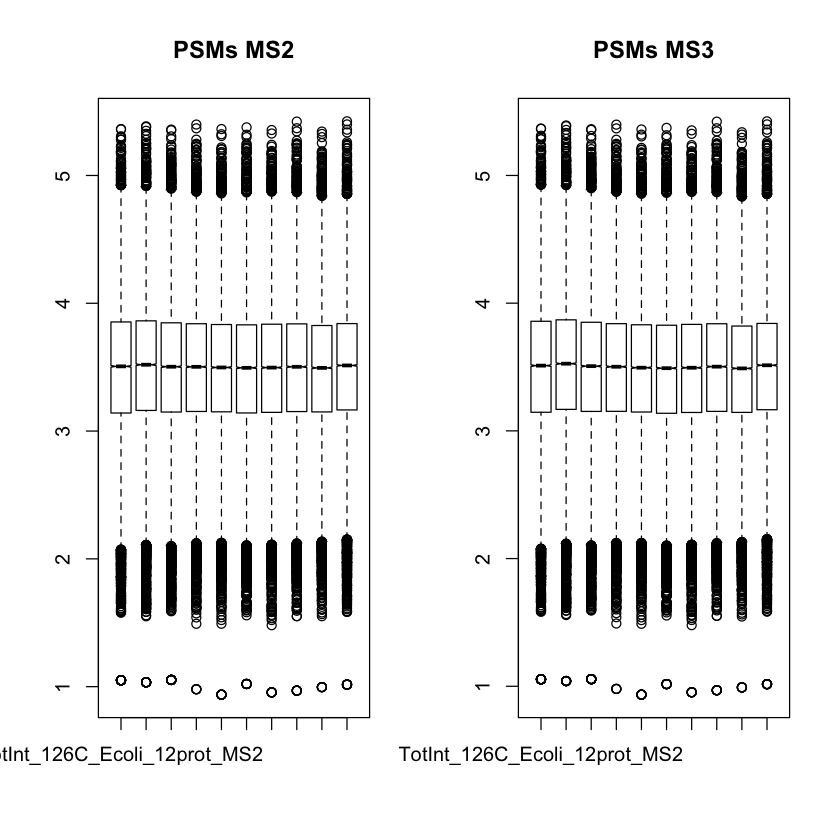

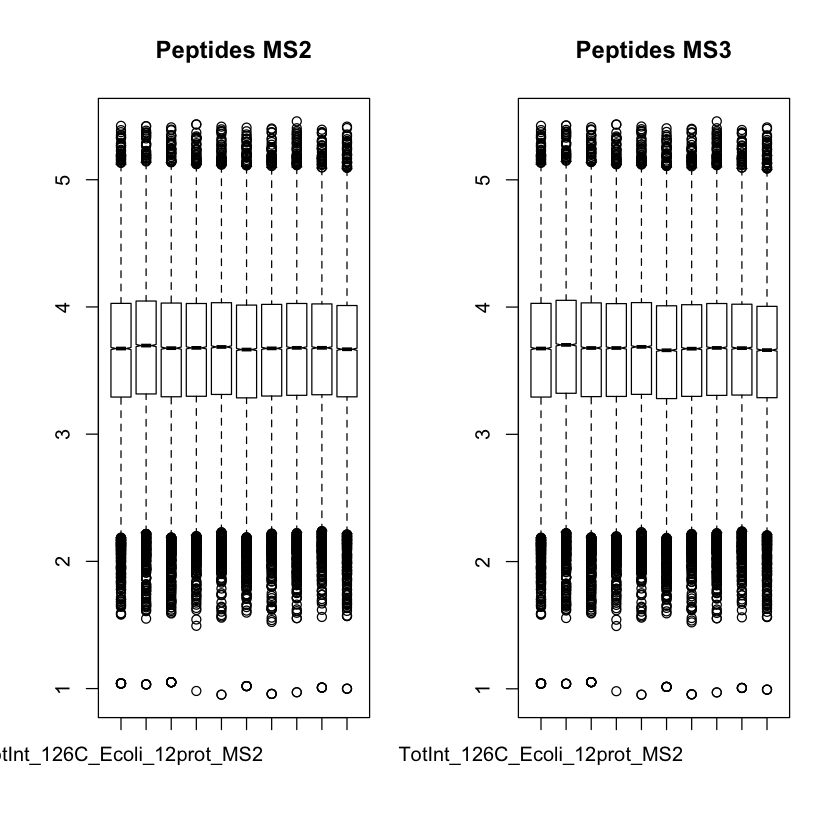

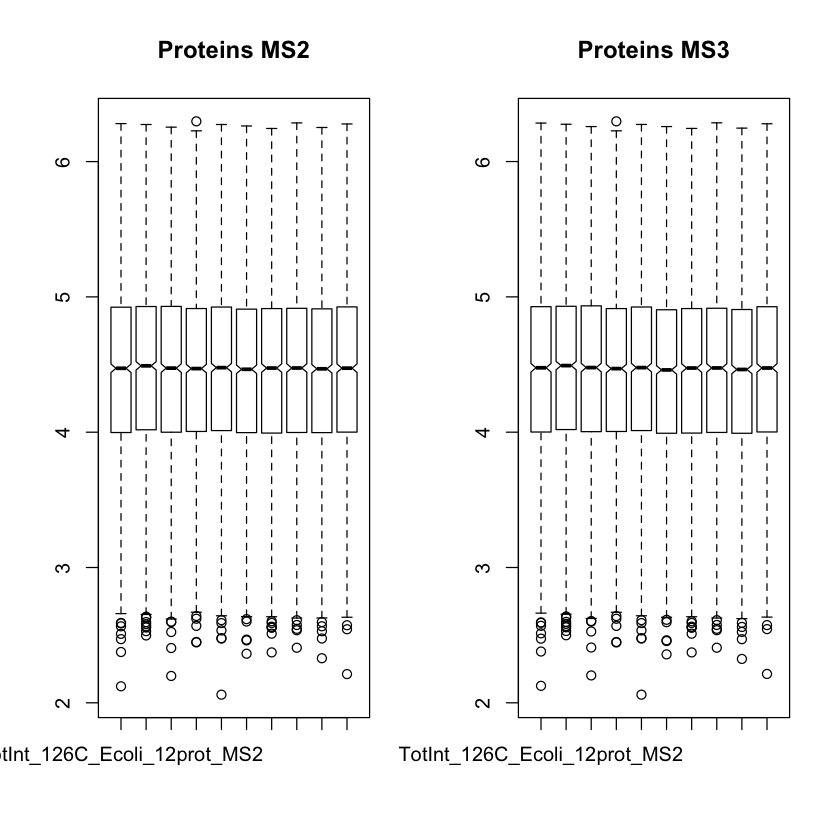

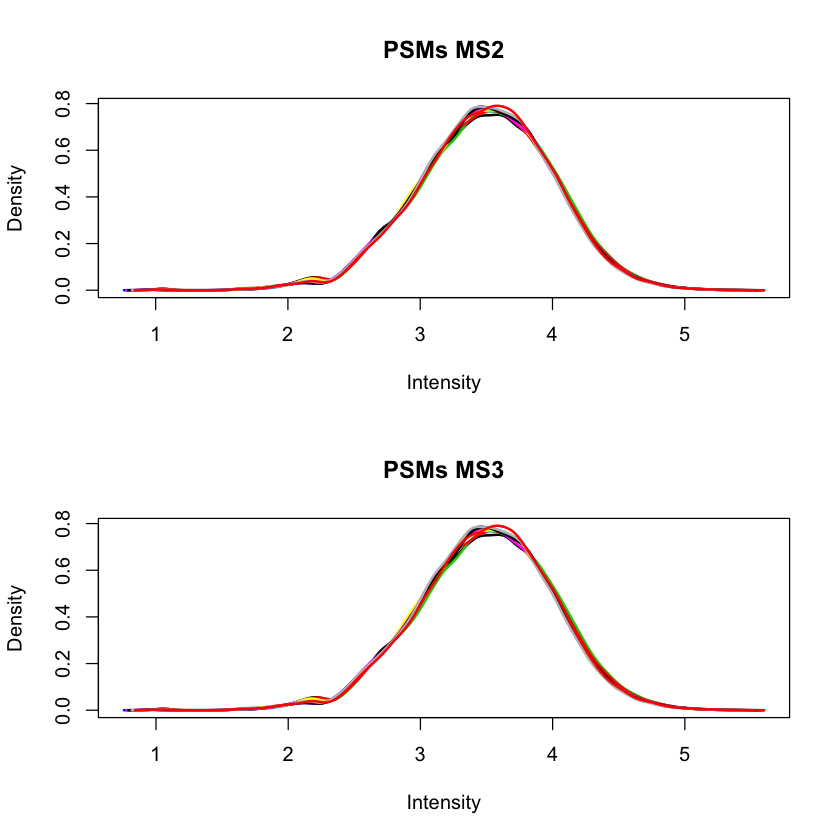

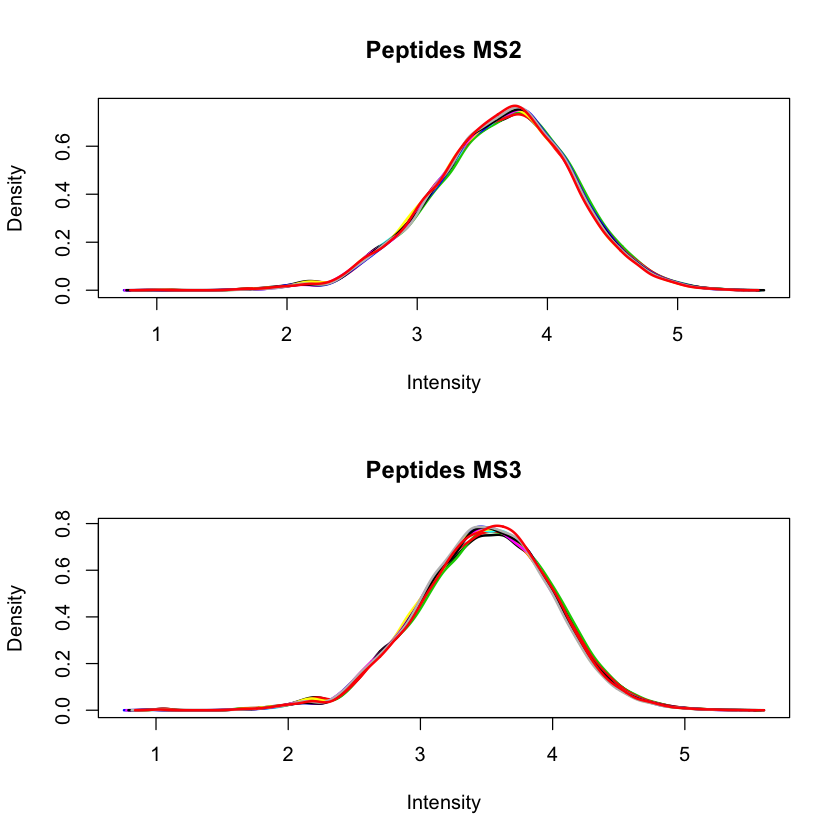

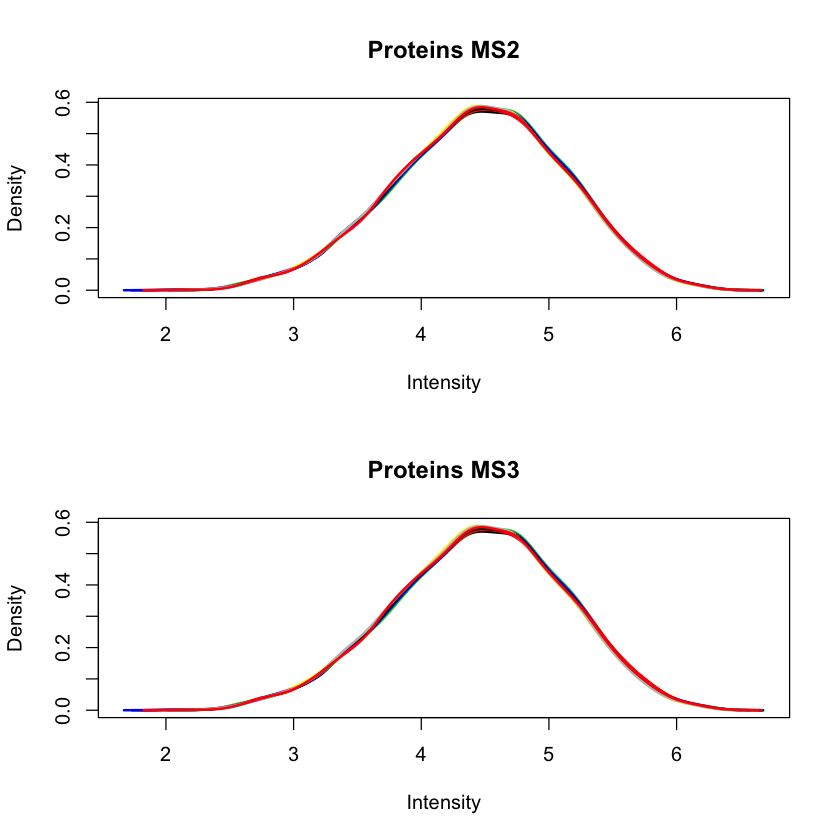

In [103]:
# compare some intensity (peak heights) distributions with box plots
par(mfrow = c(1, 2))
boxplot(log10(psm_ms2), notch = TRUE, main = "PSMs MS2")
boxplot(log10(psm_ms3), notch = TRUE, main = "PSMs MS3")
boxplot(log10(pep_ms2), notch = TRUE, main = "Peptides MS2")
boxplot(log10(pep_ms3), notch = TRUE, main = "Peptides MS3")
boxplot(log10(prot_ms2), notch = TRUE, main = "Proteins MS2")
boxplot(log10(prot_ms3), notch = TRUE, main = "Proteins MS3")

# compare some intensity (peak heights) distributions
par(mfrow = c(2, 1))
plotDensities(log10(psm_ms2), main = "PSMs MS2", legend = FALSE)
plotDensities(log10(psm_ms3), main = "PSMs MS3", legend = FALSE)
plotDensities(log10(pep_ms2), main = "Peptides MS2", legend = FALSE)
plotDensities(log10(psm_ms3), main = "Peptides MS3", legend = FALSE)
plotDensities(log10(prot_ms2), main = "Proteins MS2", legend = FALSE)
plotDensities(log10(prot_ms3), main = "Proteins MS3", legend = FALSE)

par(mfrow = c(1, 1))

# And summarize a representative channel of each dataset

In [98]:
# see what we have in the columns at each level of aggregation
print("PSM_MS2:")
summary(psm_ms2[6])
print("Peptides_MS2:")
summary(pep_ms2[6])
print("Proteins_MS2")
summary(prot_ms2[6])
print("PSM_MS3:")
summary(psm_ms3[6])
print("Peptides_MS3:")
summary(pep_ms3[6])
print("Proteins_MS3")
summary(prot_ms3[6])

[1] "PSM_MS2:"


 TotInt_129N_Ecoli_12prot_MS2
 Min.   :    10              
 1st Qu.:  1320              
 Median :  2977              
 Mean   :  5559              
 3rd Qu.:  6459              
 Max.   :226780              

[1] "Peptides_MS2:"


 TotInt_129N_Ecoli_12prot_MS2
 Min.   :    10              
 1st Qu.:  1844              
 Median :  4419              
 Mean   :  8668              
 3rd Qu.:  9886              
 Max.   :245530              

[1] "Proteins_MS2"


 TotInt_129N_Ecoli_12prot_MS2
 Min.   :    221             
 1st Qu.:   9516             
 Median :  27955             
 Mean   :  74337             
 3rd Qu.:  77740             
 Max.   :1757200             

[1] "PSM_MS3:"


 TotInt_129N_Ecoli_12prot_MS3
 Min.   :    10              
 1st Qu.:  1124              
 Median :  2464              
 Mean   :  4783              
 3rd Qu.:  5631              
 Max.   :131120              

[1] "Peptides_MS3:"


 TotInt_129N_Ecoli_12prot_MS2
 Min.   :    10              
 1st Qu.:  1493              
 Median :  3515              
 Mean   :  7547              
 3rd Qu.:  8350              
 Max.   :384120              

[1] "Proteins_MS3"


 TotInt_129N_Ecoli_12prot_MS3
 Min.   :     80.3           
 1st Qu.:   7142.2           
 Median :  22715.0           
 Mean   :  65159.8           
 3rd Qu.:  63011.2           
 Max.   :1487800.0           

# The quartile numbers (above) also indicate MS2 and MS3 are similar
The numbers are also pretty similar between PSMs and peptides. However, numbers for proteins are considerably larger suggesting most proteins are composed of many PSM observations (at least for this sample).

# Let's do the basic normalizations
Make the total signal per channel (sample loading (SL) normalization) the same:

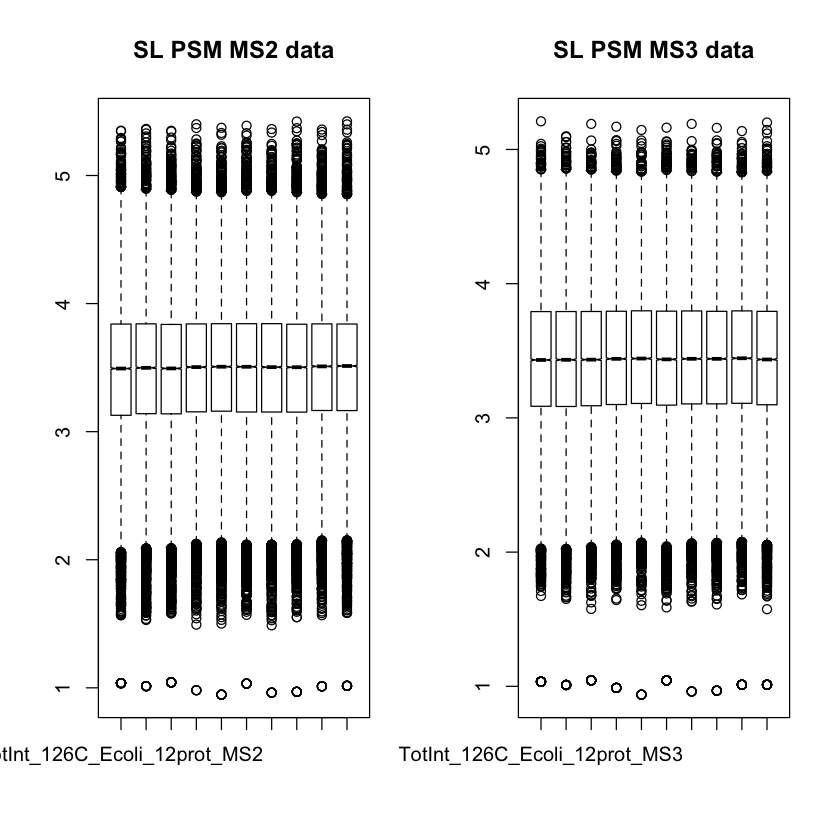

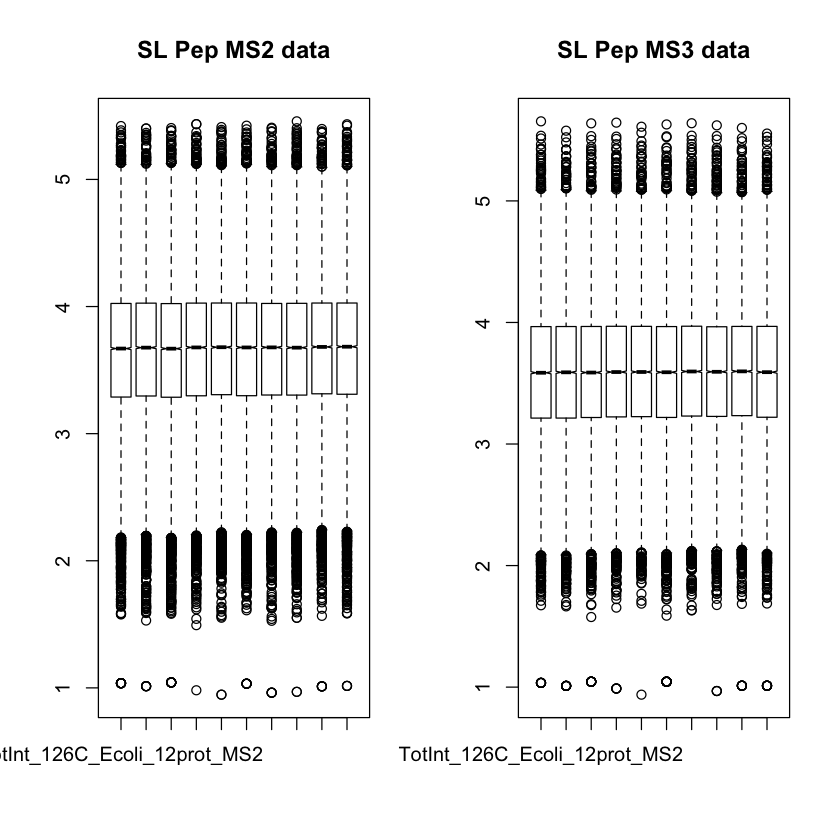

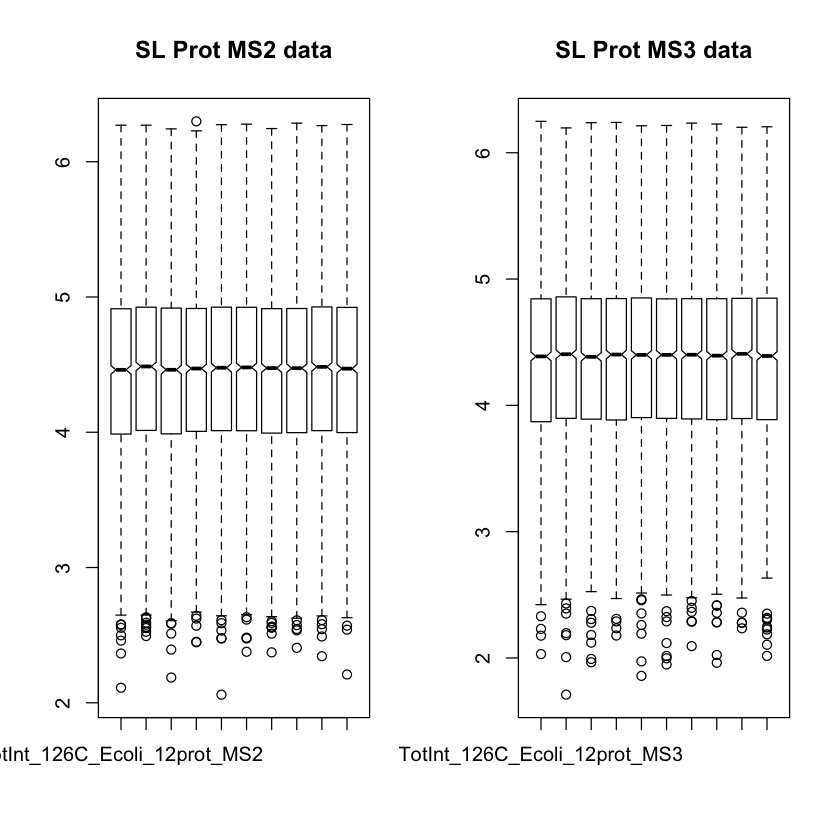

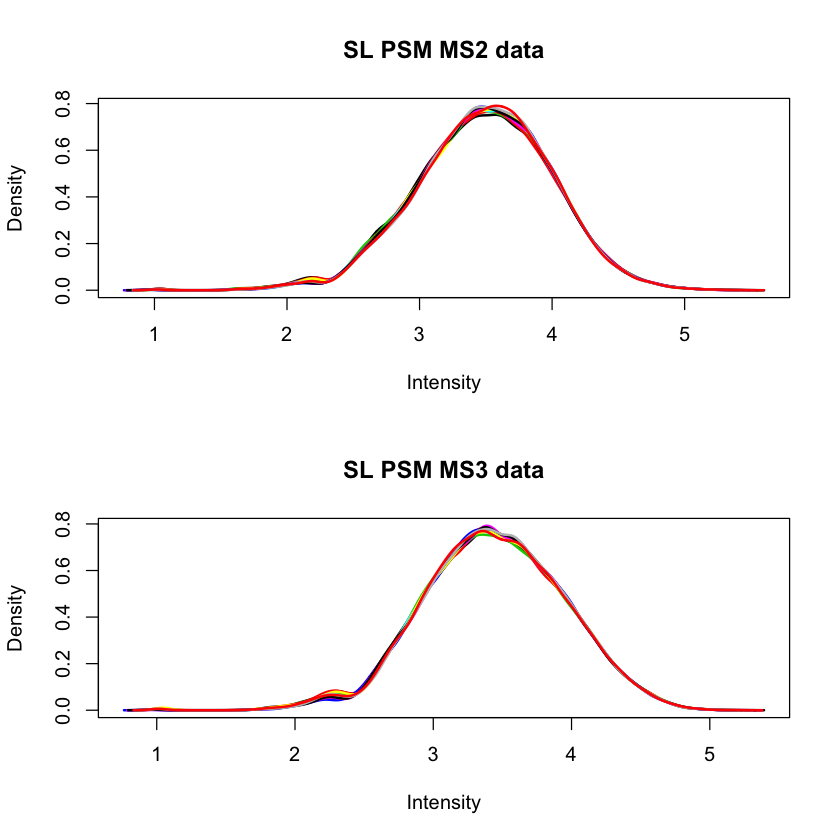

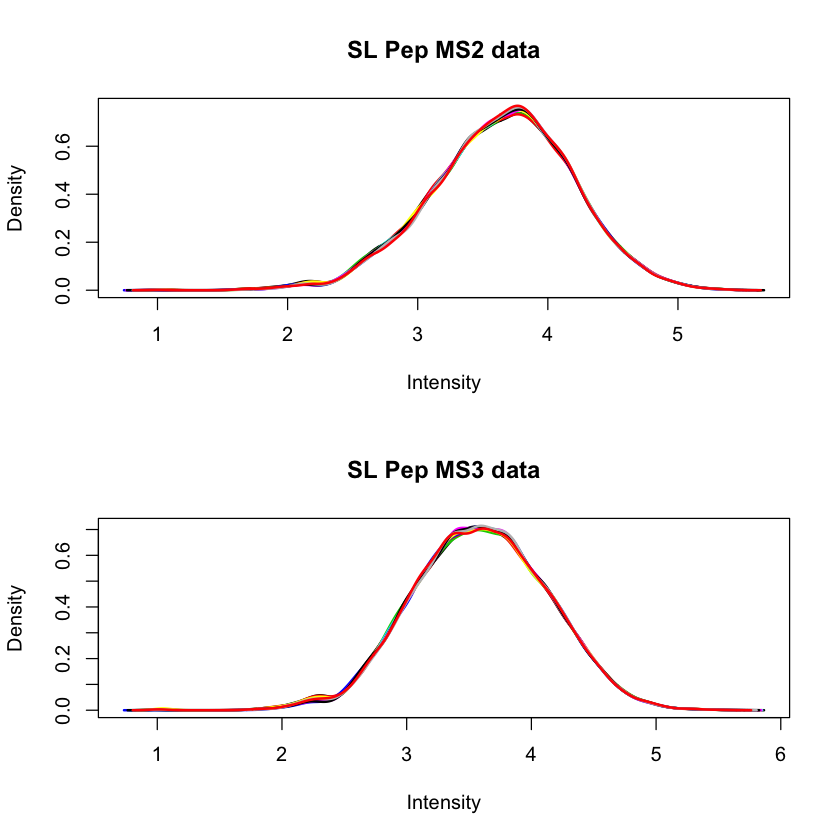

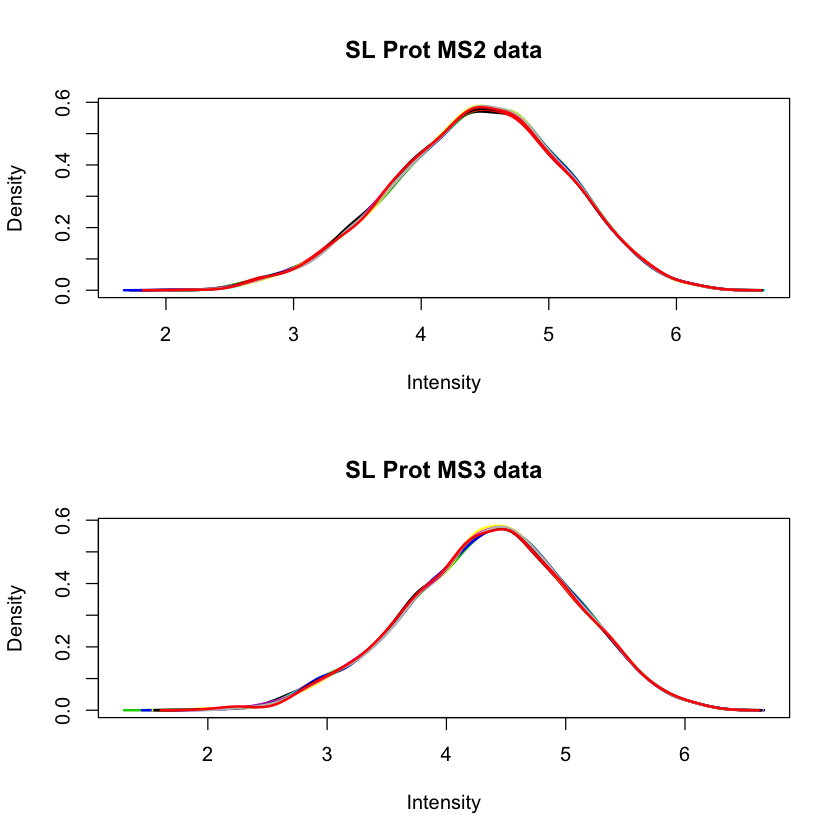

In [99]:
# figure out the global scaling values
tar_psm_ms2 <- mean(colSums(psm_ms2))
tar_pep_ms2 <- mean(colSums(pep_ms2))
tar_prot_ms2 <- mean(colSums(prot_ms2))
tar_psm_ms3 <- mean(colSums(psm_ms3))
tar_pep_ms3 <- mean(colSums(pep_ms3))
tar_prot_ms3 <- mean(colSums(prot_ms3))

# do the sample loading normalization before the IRS normalization
# there is a different correction factor for each column
facs_psm_ms2 <- tar_psm_ms2 / colSums(psm_ms2)
psm_ms2 <- sweep(psm_ms2, 2, facs_psm_ms2, FUN = "*")
facs_pep_ms2 <- tar_pep_ms2 / colSums(pep_ms2)
pep_ms2 <- sweep(pep_ms2, 2, facs_pep_ms2, FUN = "*")
facs_prot_ms2 <- tar_prot_ms2 / colSums(prot_ms2)
prot_ms2 <- sweep(prot_ms2, 2, facs_prot_ms2, FUN = "*")
facs_psm_ms3 <- tar_psm_ms3 / colSums(psm_ms3)
psm_ms3 <- sweep(psm_ms3, 2, facs_psm_ms3, FUN = "*")
facs_pep_ms3 <- tar_pep_ms3 / colSums(pep_ms3)
pep_ms3 <- sweep(pep_ms3, 2, facs_pep_ms3, FUN = "*")
facs_prot_ms3 <- tar_prot_ms3 / colSums(prot_ms3)
prot_ms3 <- sweep(prot_ms3, 2, facs_prot_ms3, FUN = "*")

# see what the SL normalized data look like
par(mfrow = c(1, 2))
boxplot(log10(psm_ms2), notch = TRUE, main = "SL PSM MS2 data")
boxplot(log10(psm_ms3), notch = TRUE, main = "SL PSM MS3 data")
boxplot(log10(pep_ms2), notch = TRUE, main = "SL Pep MS2 data")
boxplot(log10(pep_ms3), notch = TRUE, main = "SL Pep MS3 data")
boxplot(log10(prot_ms2), notch = TRUE, main = "SL Prot MS2 data")
boxplot(log10(prot_ms3), notch = TRUE, main = "SL Prot MS3 data")

# NOTE: density distributions order samples differently than box plots...
par(mfrow = c(2, 1))
plotDensities(log10(psm_ms2), legend = FALSE, main = "SL PSM MS2 data")
plotDensities(log10(psm_ms3), legend = FALSE, main = "SL PSM MS3 data")
plotDensities(log10(pep_ms2), legend = FALSE, main = "SL Pep MS2 data")
plotDensities(log10(pep_ms3), legend = FALSE, main = "SL Pep MS3 data")
plotDensities(log10(prot_ms2), legend = FALSE, main = "SL Prot MS2 data")
plotDensities(log10(prot_ms3), legend = FALSE, main = "SL Prot MS3 data")
par(mfrow = c(1, 1))

# Add the edgeR TMM normalization (it may not do much for this data)

[1] "Print the TMM correction factors (MS2 proteins then MS3 proteins:"


[1] 0.9916752 0.9966960 0.9910586 1.0008258 0.9999151 1.0111036 1.0002150
 [8] 0.9994243 1.0116387 0.9976600

[1] 0.9916738 0.9966972 0.9910571 1.0008253 0.9999168 1.0111039 1.0002144
 [8] 0.9994238 1.0116406 0.9976592

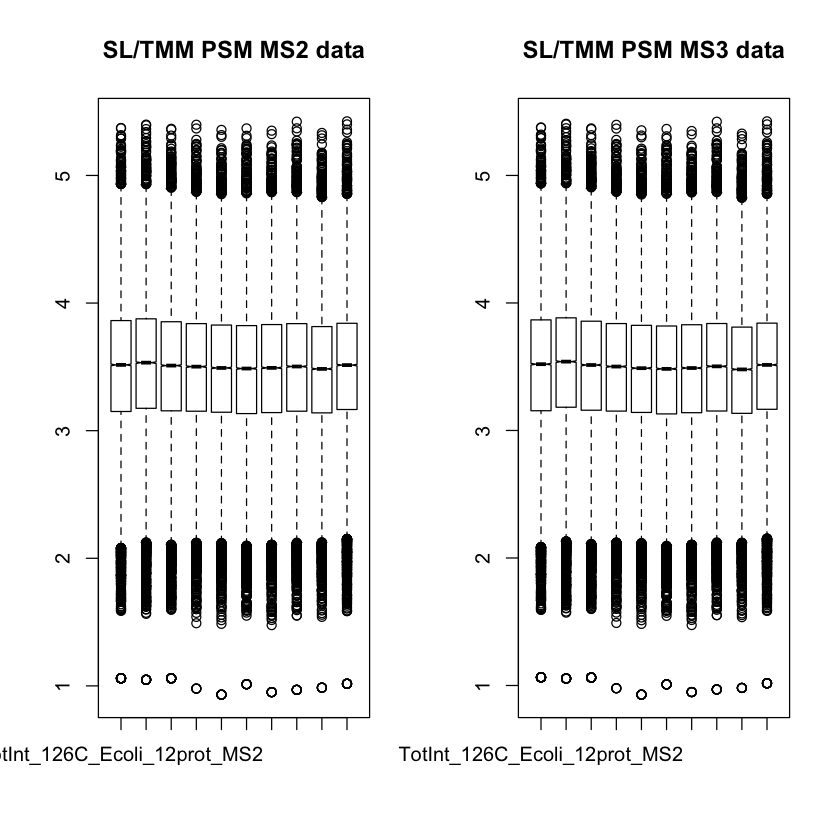

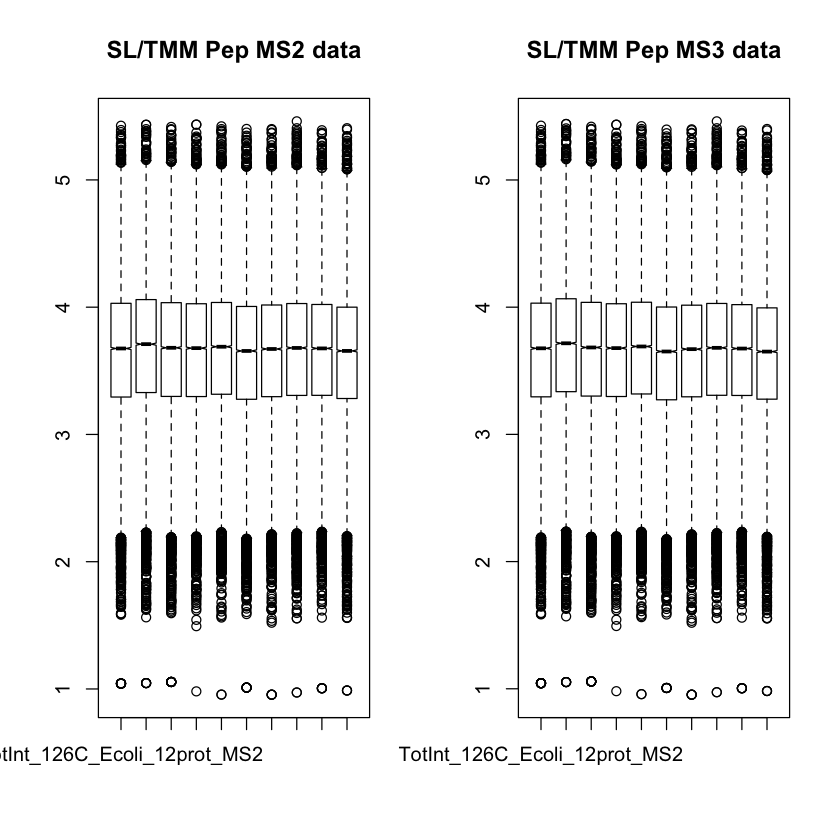

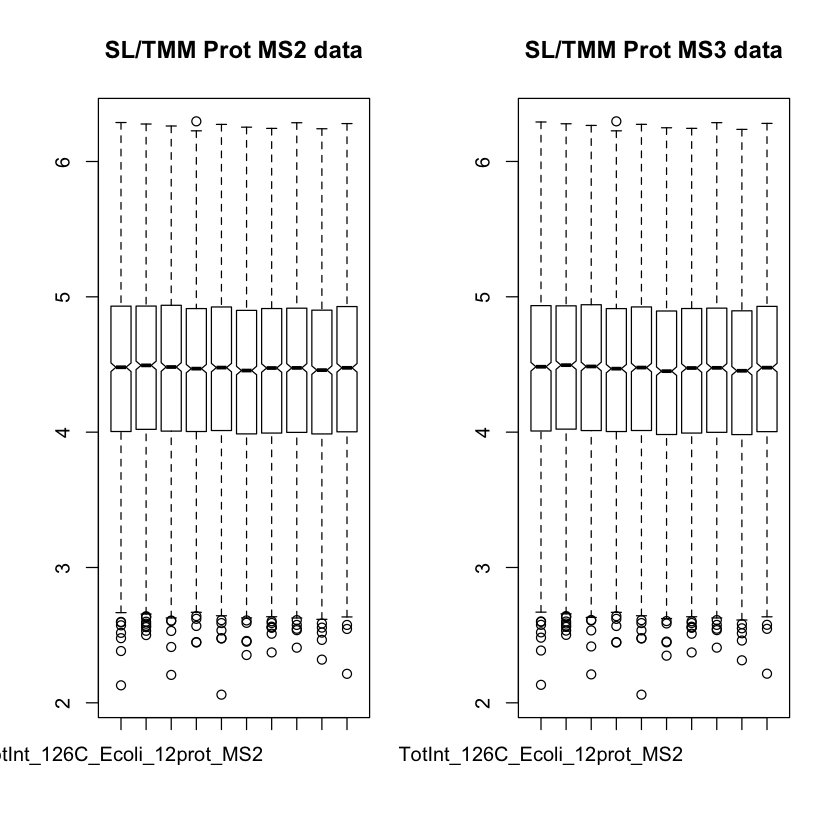

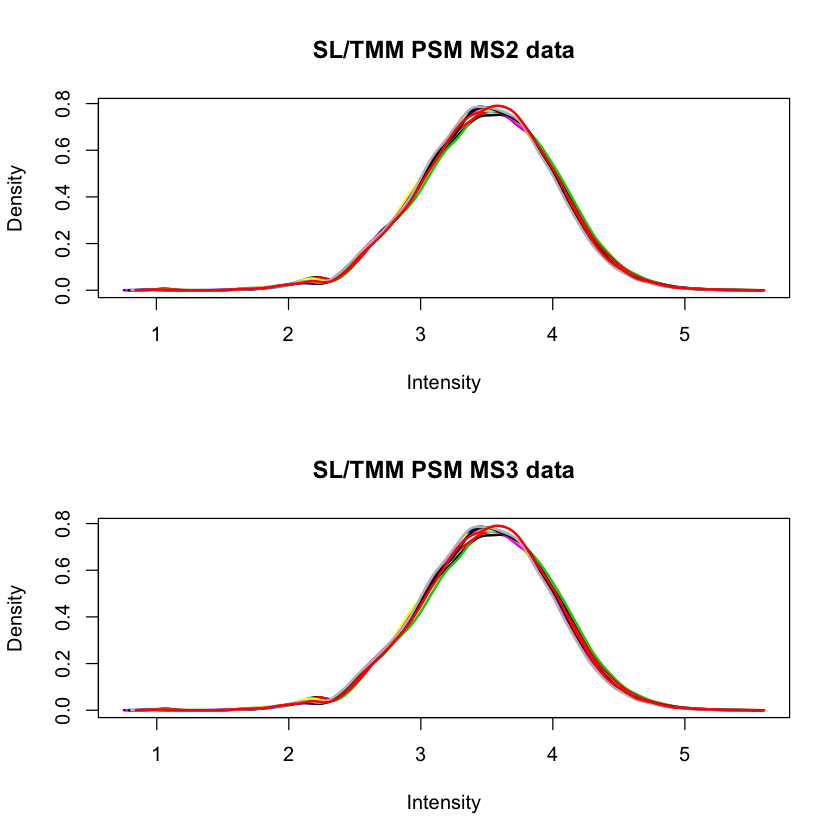

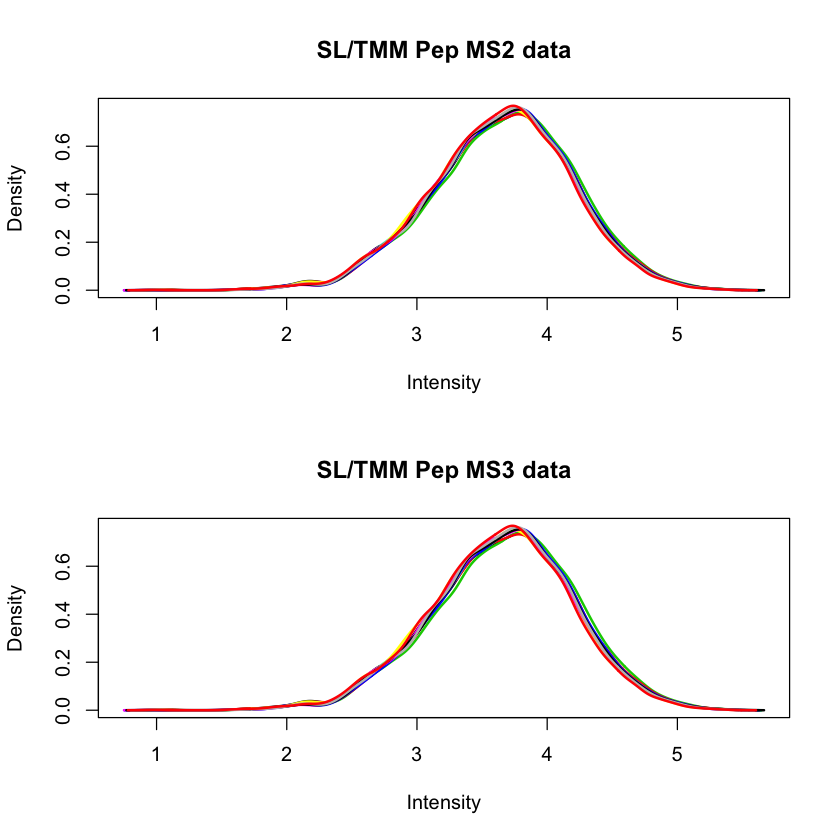

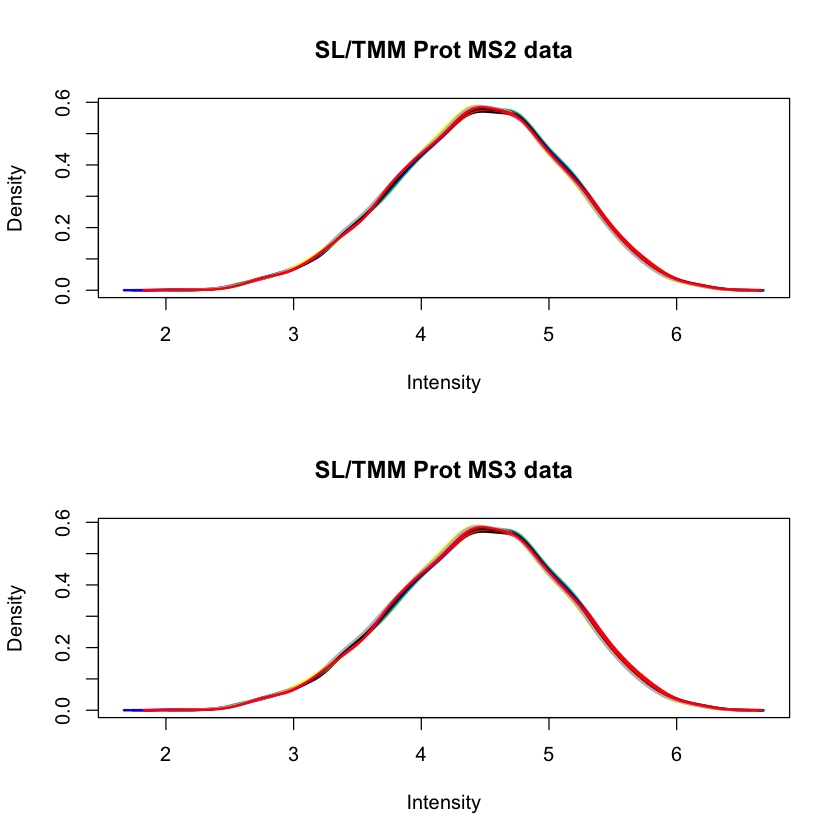

In [111]:
# do TMM on data
psm_ms2_tmm <- calcNormFactors(psm_ms2)
psm_ms2 <- sweep(psm_ms2, 2, psm_ms2_tmm, FUN = "/") # this is data after SL and TMM on original scale
pep_ms2_tmm <- calcNormFactors(pep_ms2)
pep_ms2 <- sweep(pep_ms2, 2, pep_ms2_tmm, FUN = "/") # this is data after SL and TMM on original scale
print("Print the TMM correction factors (MS2 proteins then MS3 proteins:")
(prot_ms2_tmm <- calcNormFactors(prot_ms2))
prot_ms2 <- sweep(prot_ms2, 2, prot_ms2_tmm, FUN = "/") # this is data after SL and TMM on original scale

psm_ms3_tmm <- calcNormFactors(psm_ms3)
psm_ms3 <- sweep(psm_ms2, 2, psm_ms3_tmm, FUN = "/") # this is data after SL and TMM on original scale
pep_ms3_tmm <- calcNormFactors(pep_ms3)
pep_ms3 <- sweep(pep_ms2, 2, pep_ms3_tmm, FUN = "/") # this is data after SL and TMM on original scale
(prot_ms3_tmm <- calcNormFactors(prot_ms3))
prot_ms3 <- sweep(prot_ms2, 2, prot_ms3_tmm, FUN = "/") # this is data after SL and TMM on original scale

# see what the SL/TMM normalized data look like
par(mfrow = c(1, 2))
boxplot(log10(psm_ms2), notch = TRUE, main = "SL/TMM PSM MS2 data")
boxplot(log10(psm_ms3), notch = TRUE, main = "SL/TMM PSM MS3 data")
boxplot(log10(pep_ms2), notch = TRUE, main = "SL/TMM Pep MS2 data")
boxplot(log10(pep_ms3), notch = TRUE, main = "SL/TMM Pep MS3 data")
boxplot(log10(prot_ms2), notch = TRUE, main = "SL/TMM Prot MS2 data")
boxplot(log10(prot_ms3), notch = TRUE, main = "SL/TMM Prot MS3 data")

# NOTE: density distributions order samples differently than box plots...
par(mfrow = c(2, 1))
plotDensities(log10(psm_ms2), legend = FALSE, main = "SL/TMM PSM MS2 data")
plotDensities(log10(psm_ms3), legend = FALSE, main = "SL/TMM PSM MS3 data")
plotDensities(log10(pep_ms2), legend = FALSE, main = "SL/TMM Pep MS2 data")
plotDensities(log10(pep_ms3), legend = FALSE, main = "SL/TMM Pep MS3 data")
plotDensities(log10(prot_ms2), legend = FALSE, main = "SL/TMM Prot MS2 data")
plotDensities(log10(prot_ms3), legend = FALSE, main = "SL/TMM Prot MS3 data")
par(mfrow = c(1, 1))

# save the normalized data frames
psm_ms2_norm <- psm_ms2
psm_ms3_norm <- psm_ms3
pep_ms2_norm <- pep_ms2
pep_ms3_norm <- pep_ms3
prot_ms2_norm <- prot_ms2
prot_ms3_norm <- prot_ms3

# TMM was not really needed because the samples are so similar
Regardless, the data from either method across all the aggregation levels are very nicely normalized.

# Prepare the data for plotting
We will use the average of the 10 intensities as the x-axis and plot each channel against that. The first plots will be linear scale for the MS2 method data. The first block of 10 are at the PSM level, the next block at the peptide level, and the last block is the protein level.

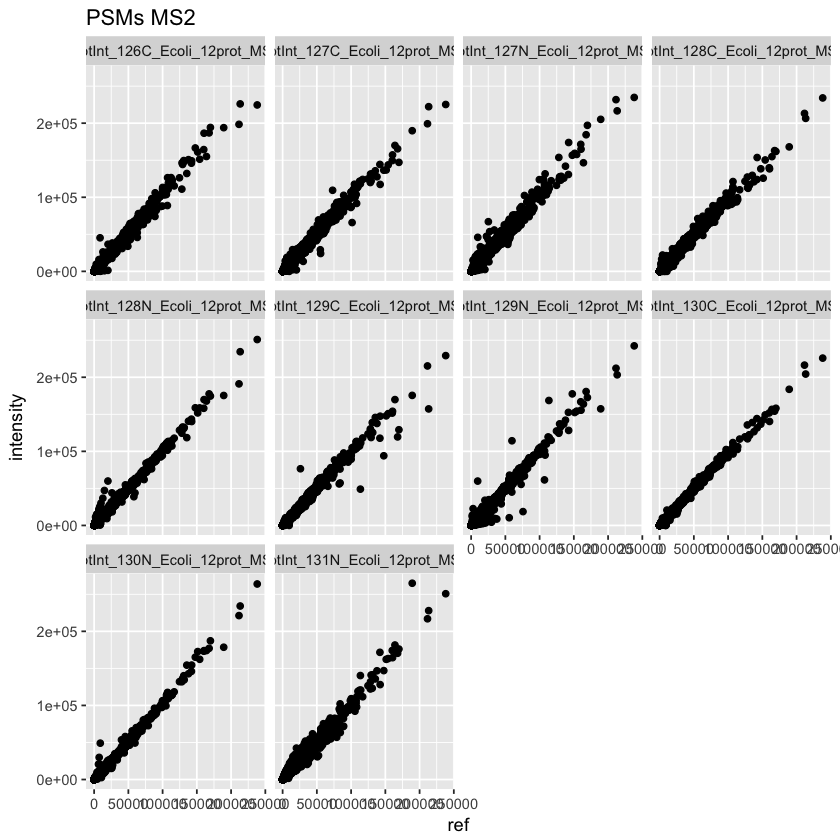

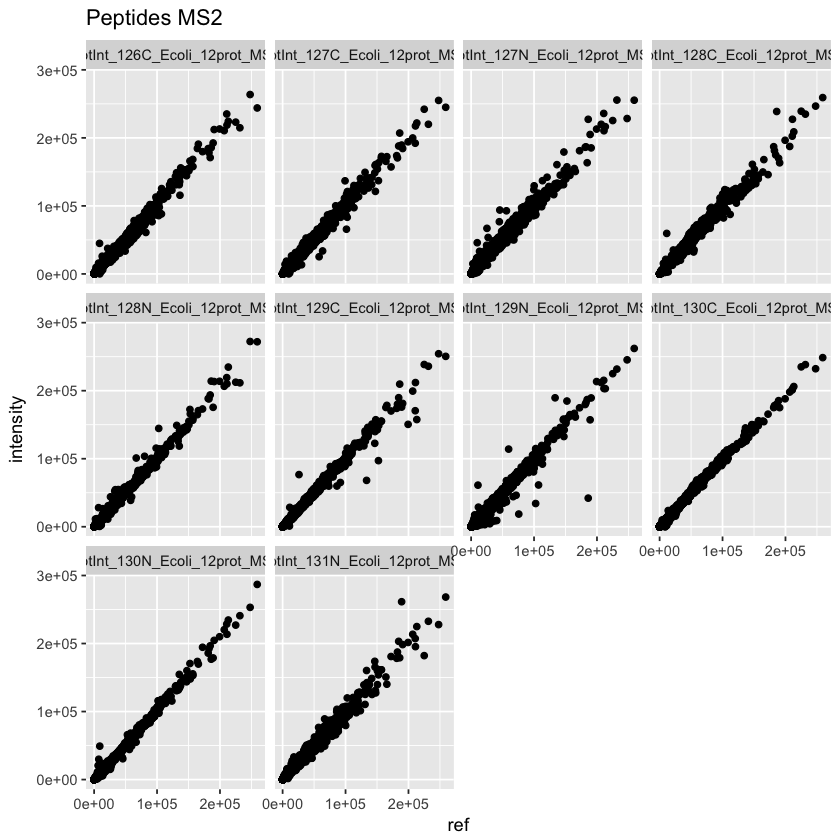

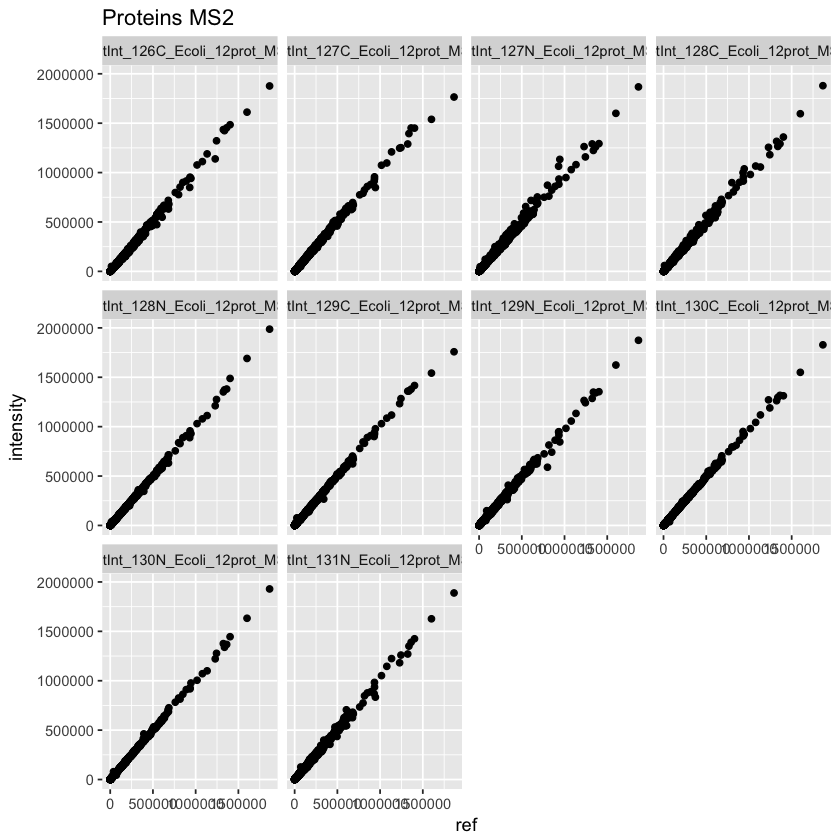

In [81]:
# create an average vector for the x-axis
psm_ms2$ref <- rowMeans(psm_ms2)
pep_ms2$ref <- rowMeans(pep_ms2)
prot_ms2$ref <- rowMeans(prot_ms2)
psm_ms3$ref <- rowMeans(psm_ms3)
pep_ms3$ref <- rowMeans(pep_ms3)
prot_ms3$ref <- rowMeans(prot_ms3)

# linear scales (thank you stack exchange - plotting setup in ggplot is very different...)
psm_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("PSMs MS2")

pep_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("Peptides MS2")

prot_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("Proteins MS2")

# Now look at the MS3 method data
Same linear scales of the PSMs, the peptides, and then the proteins.

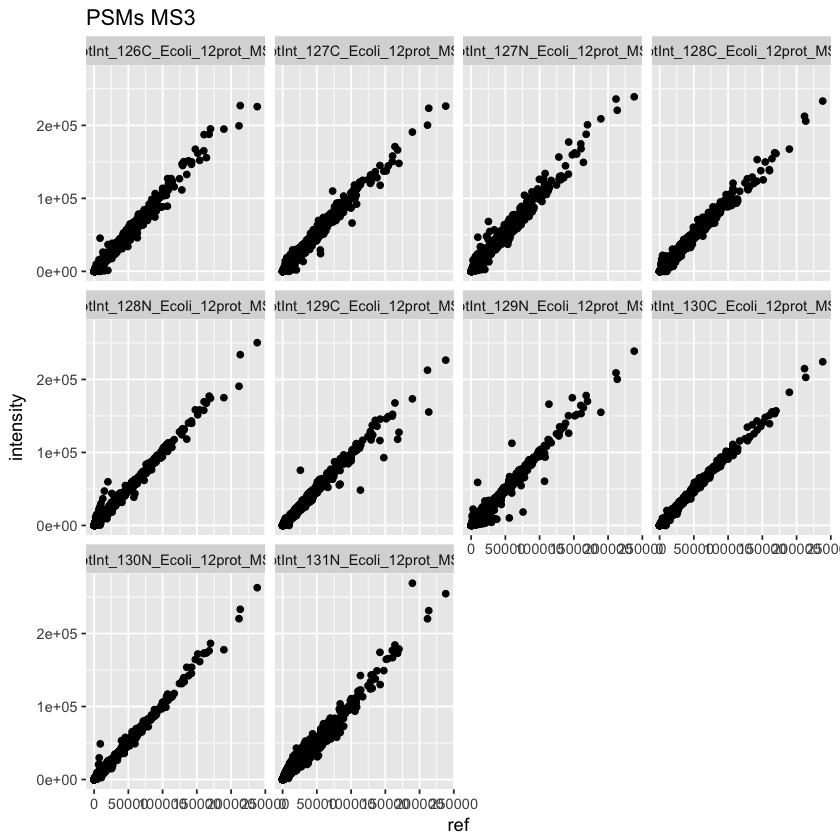

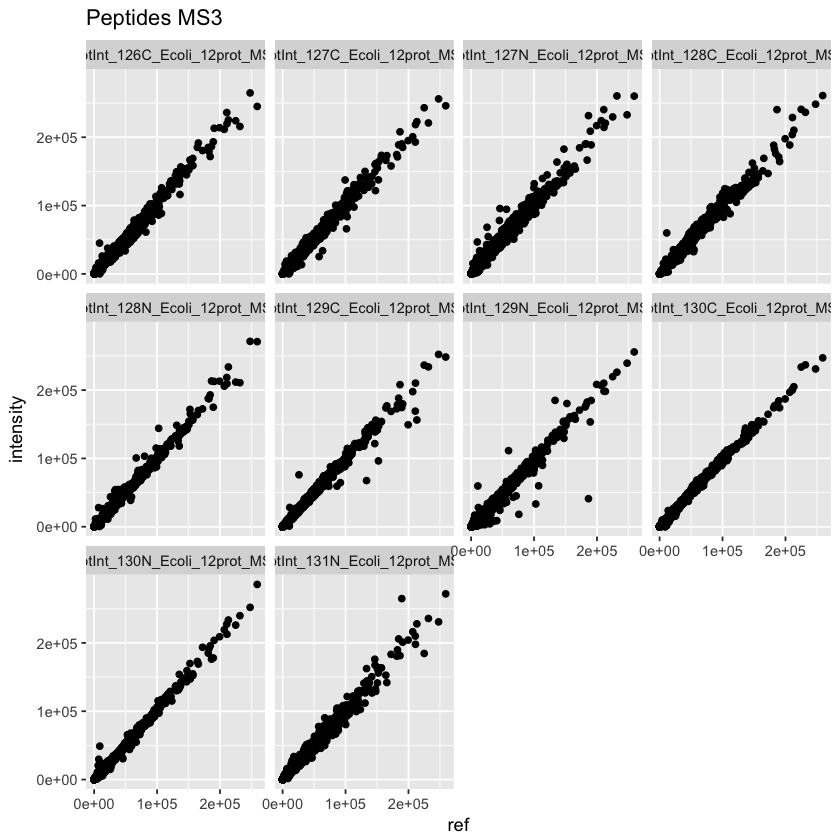

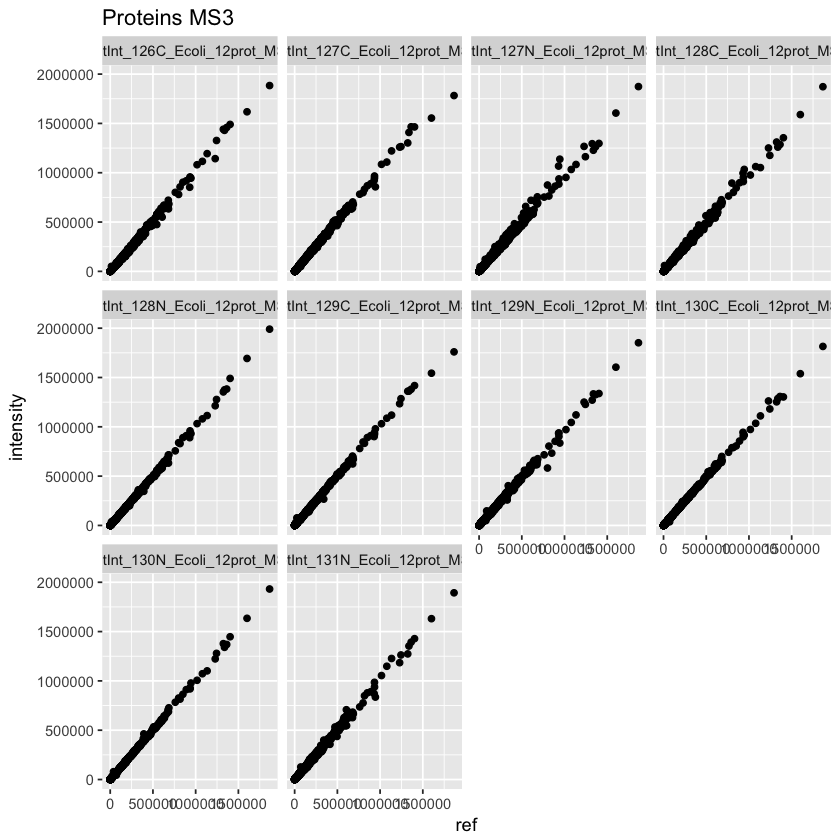

In [82]:
psm_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("PSMs MS3")

pep_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("Peptides MS3")

prot_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("Proteins MS3")

# Same data as above but on log10 scales
The MS2 method data first (PSM, peptide, and protein).

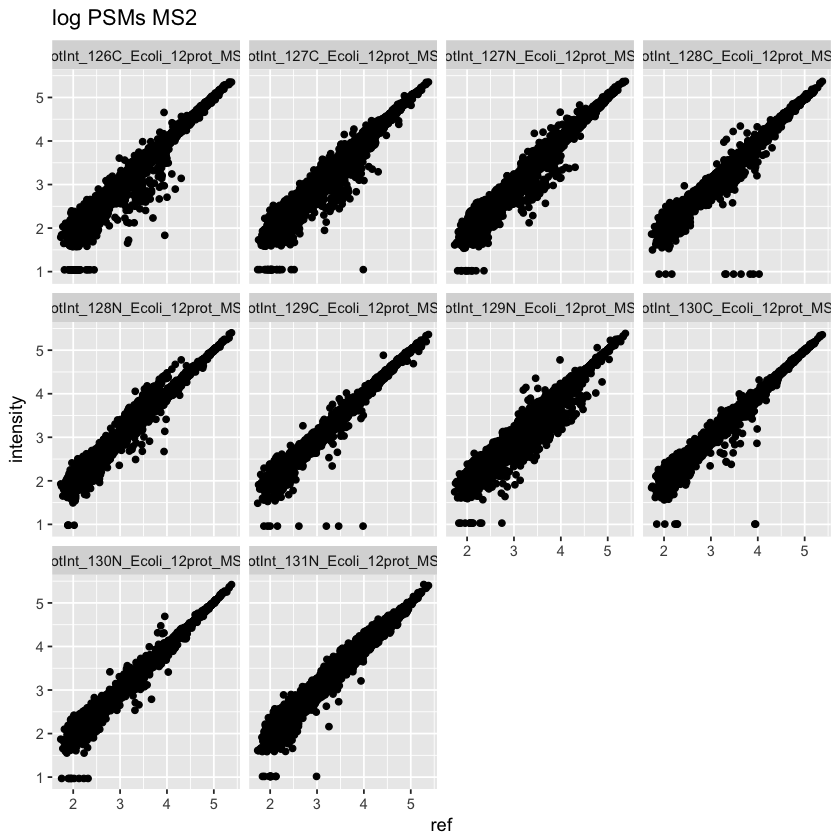

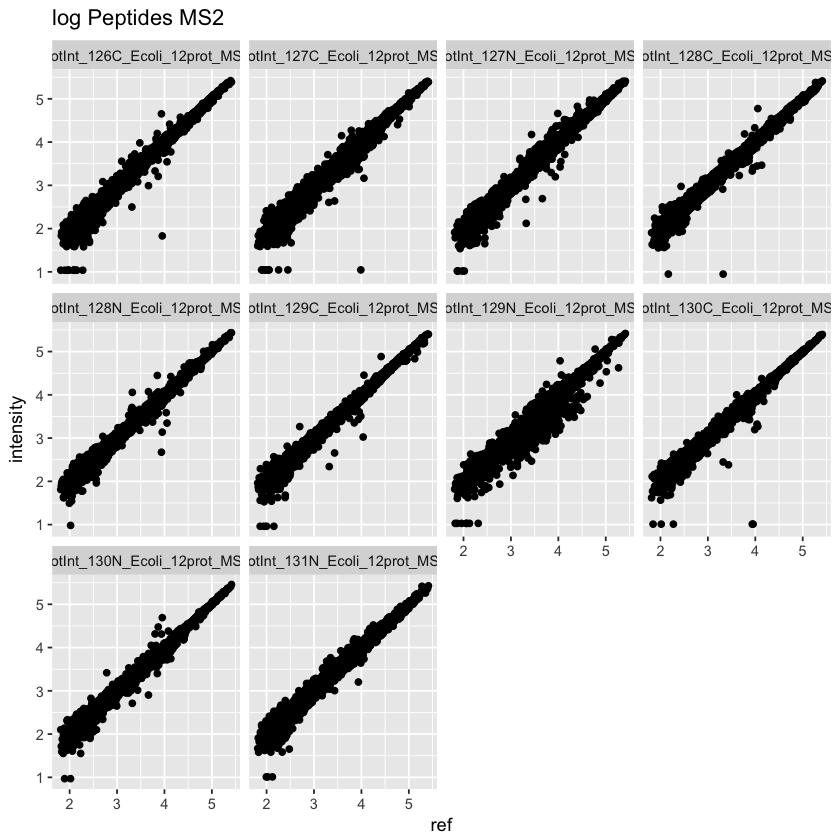

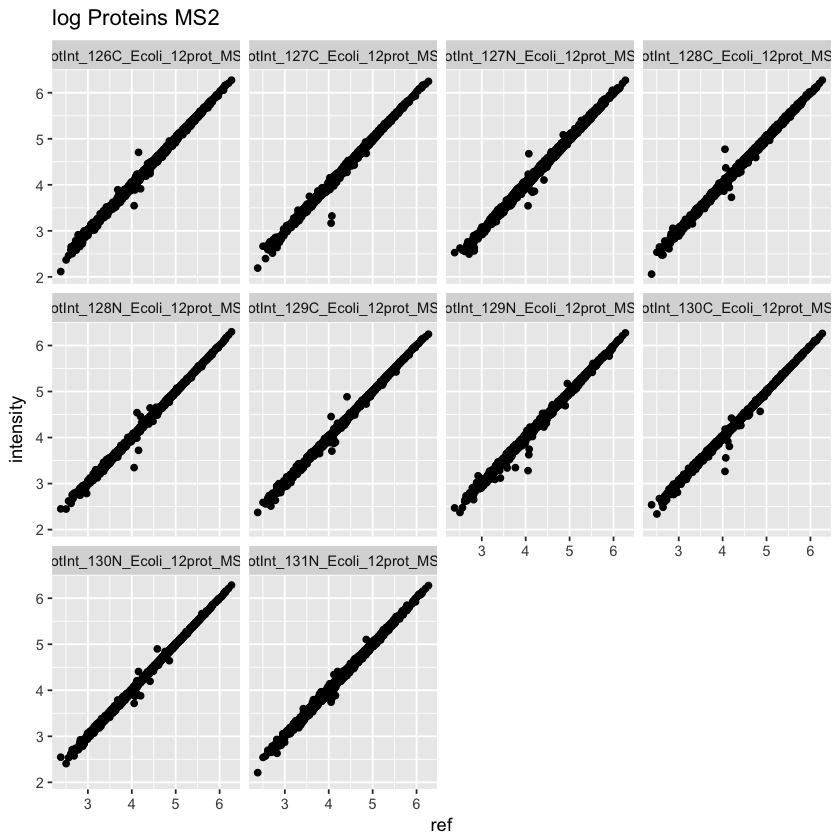

In [83]:
# log scales
log_psm_ms2 <- log10(psm_ms2)
log_pep_ms2 <- log10(pep_ms2)
log_prot_ms2 <- log10(prot_ms2)
log_psm_ms3 <- log10(psm_ms3)
log_pep_ms3 <- log10(pep_ms3)
log_prot_ms3 <- log10(prot_ms3)

log_psm_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log PSMs MS2")

log_pep_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log Peptides MS2")

log_prot_ms2 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log Proteins MS2")

# And the log10 for the MS3 method data

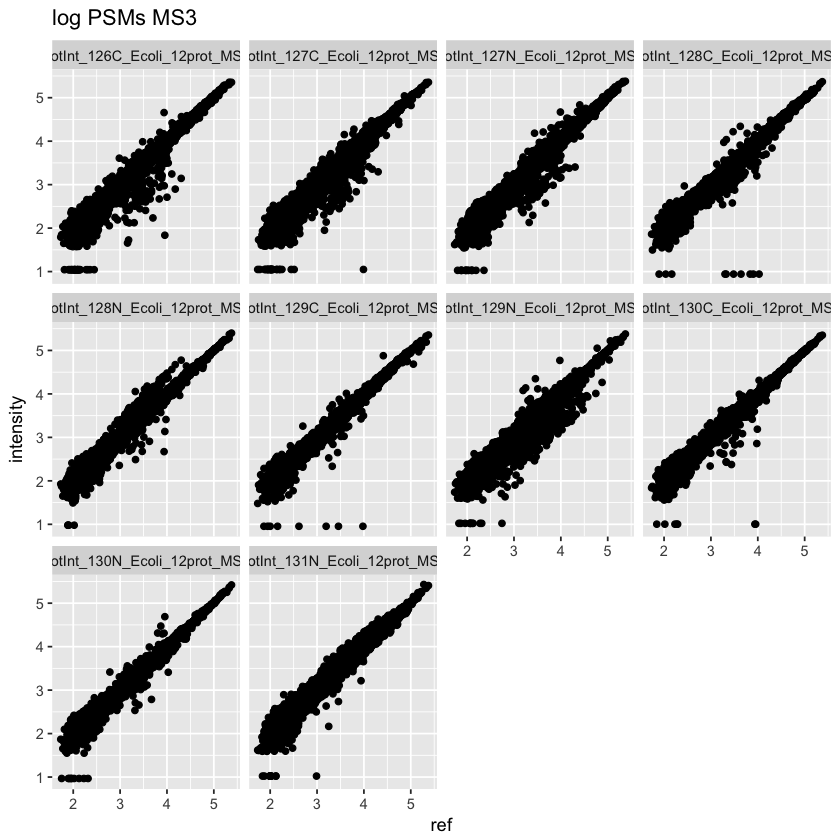

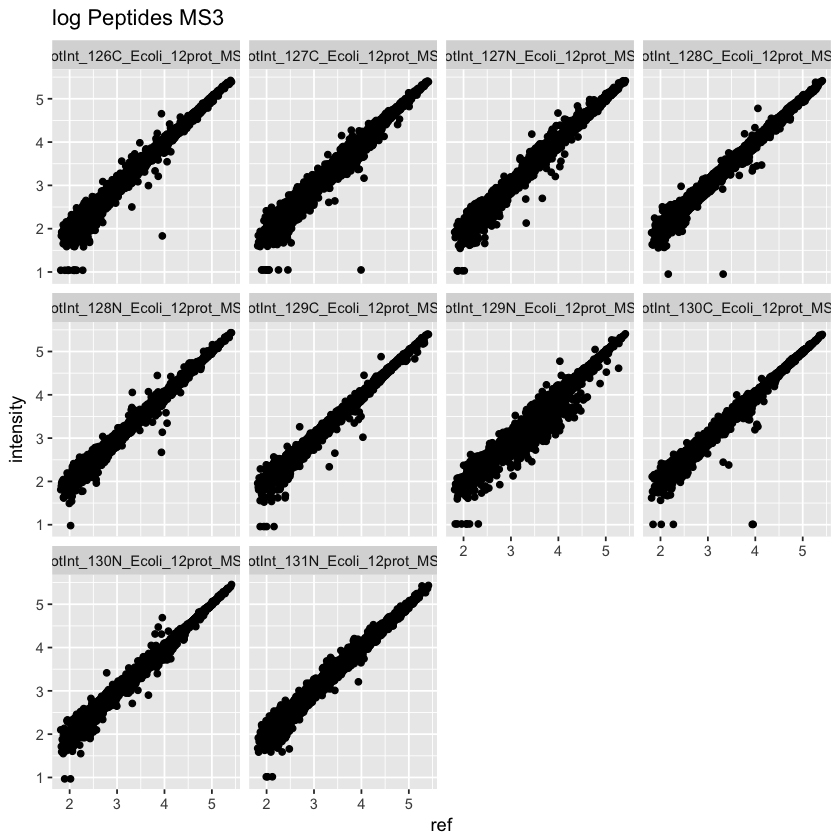

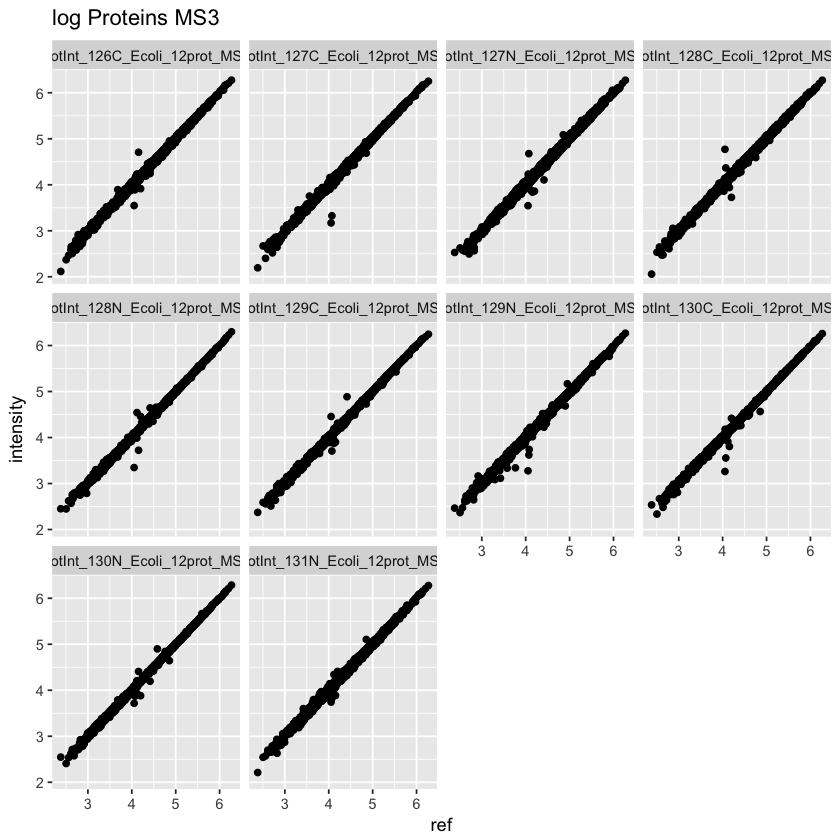

In [84]:
log_psm_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log PSMs MS3")

log_pep_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log Peptides MS3")

log_prot_ms3 %>% 
  gather(channel, intensity, -ref) %>%
  ggplot(aes(ref, intensity)) + geom_point() + facet_wrap(~channel) + ggtitle("log Proteins MS3")

# Protein level data is much "tighter" than PSM or peptide data

### NOTE: This data does not shed any light on dynamic range compression in MS2-based methods compared to SPS MS3 methods. All of the E. coli proteins are present at similar concentrations in each TMT channel.
<br>
We can quantify what we see in the above scatter plots by computing the coefficient of variance (CV) distributions. We can see how the PSM, peptide, and protein aggregation levels compare, and see if the MS2 method differs much from the MS3 method.

[1] "MS2 method (PSMs, peptides, proteins)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.069   8.262  11.042  13.534  15.426 237.939 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.19    6.63    9.34   11.37   13.26  174.01 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.753   5.080   6.346   7.322   8.236 165.372 

[1] "MS3 method (PSMs, peptides, proteins)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.334   8.708  11.417  13.870  15.692 237.265 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.416   6.961   9.672  11.664  13.618 173.992 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.966   5.536   6.674   7.625   8.439 165.329 

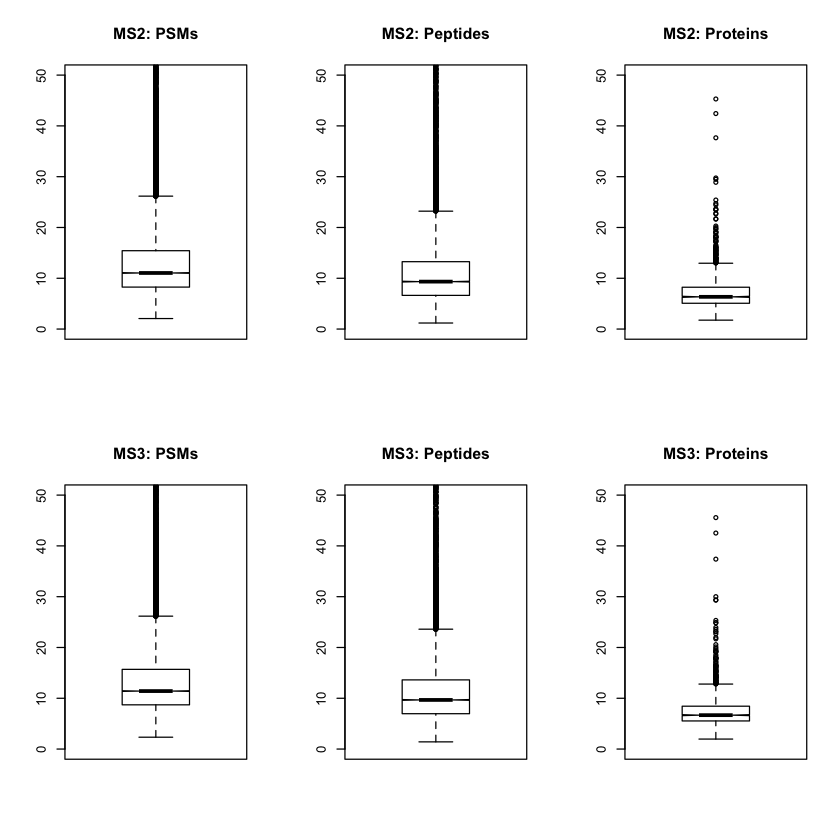

In [112]:
# define a function for computing CVs
compute_cv <- function(temp) {
  cv <- 100 * apply(temp, 1, sd) / rowMeans(temp)
}

# compute the CVs and look at the distributions
print("MS2 method (PSMs, peptides, proteins)")
summary(compute_cv(psm_ms2))
summary(compute_cv(pep_ms2))
summary(compute_cv(prot_ms2))

print("MS3 method (PSMs, peptides, proteins)")
summary(compute_cv(psm_ms3))
summary(compute_cv(pep_ms3))
summary(compute_cv(prot_ms3))

# make some box plots, too
par(mfrow = c(2, 3))
boxplot(compute_cv(psm_ms2), ylim = c(0, 50), notch = TRUE, main = "MS2: PSMs")
boxplot(compute_cv(pep_ms2), ylim = c(0, 50), notch = TRUE, main = "MS2: Peptides")
boxplot(compute_cv(prot_ms2), ylim = c(0, 50), notch = TRUE, main = "MS2: Proteins")
boxplot(compute_cv(psm_ms3), ylim = c(0, 50), notch = TRUE, main = "MS3: PSMs")
boxplot(compute_cv(pep_ms3), ylim = c(0, 50), notch = TRUE, main = "MS3: Peptides")
boxplot(compute_cv(prot_ms3), ylim = c(0, 50), notch = TRUE, main = "MS3: Proteins")
par(mfrow = c(1, 1))

# Protein level summarization is less noisy compared to PSM or peptide level
The more summing of signals, the better the data gets. Peptides are a little better than PSMs, and we see the median CV drop from about 11% to 9%. Proteins are quite a bit better with median CV down to 6%. We do not see much difference between variance in the MS2 method data compared to the MS3 method data.

# Last thing: check clustering
The data across the channels is the same E. coli background. We should not have any structure in the MDS plots.

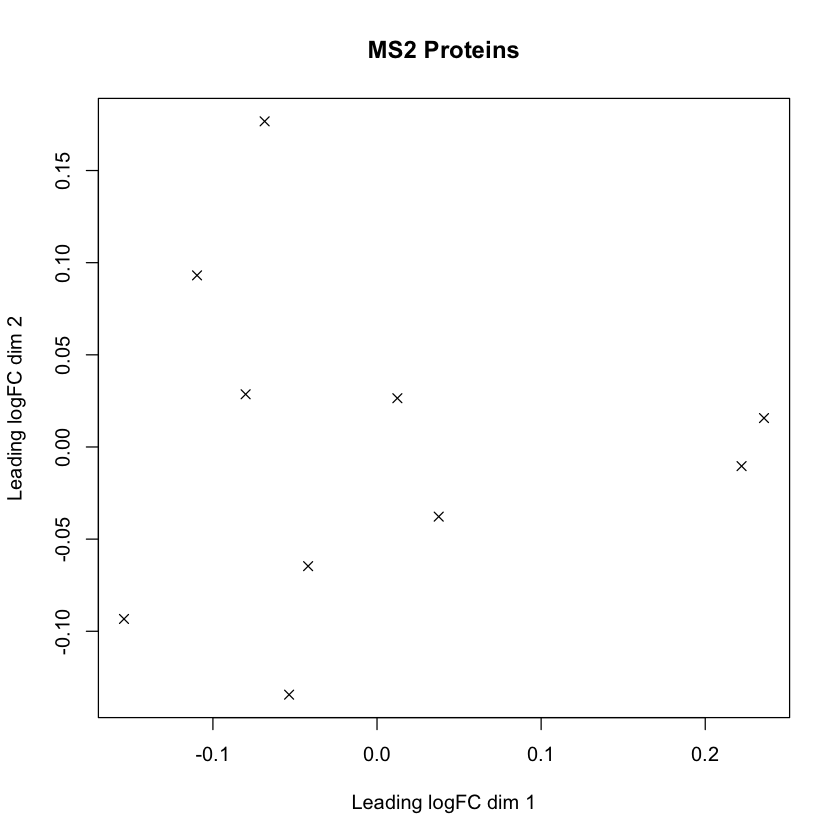

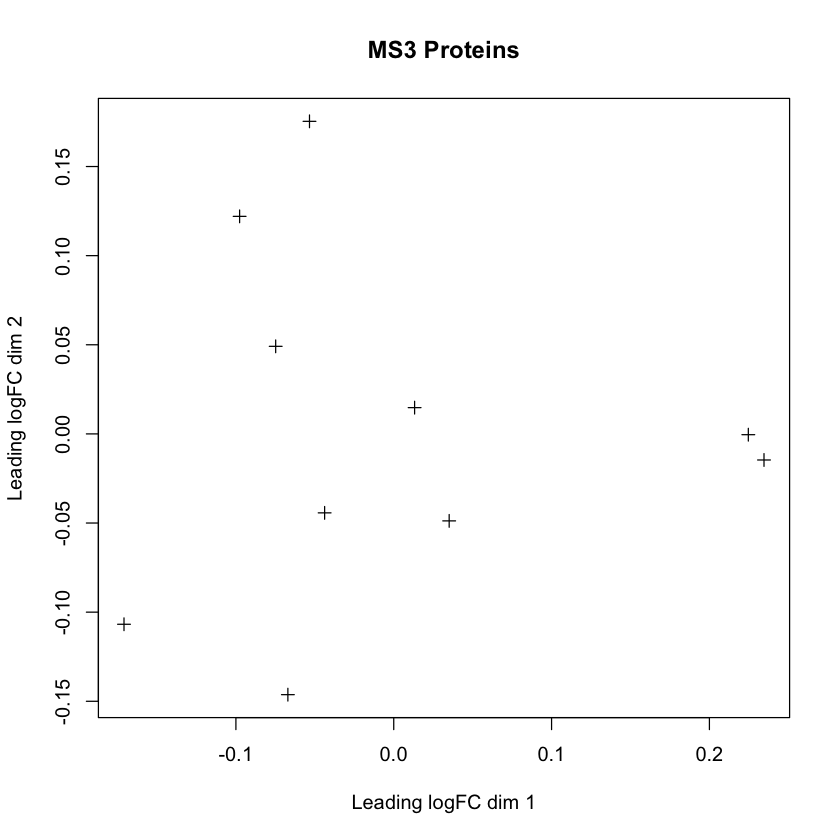

In [115]:
# check clustering at the protein level betwen MS2 and MS3 methods
plotMDS(log2(prot_ms2), pch = 4, main = "MS2 Proteins")
plotMDS(log2(prot_ms3), pch = 3, main = "MS3 Proteins")

# Conclusions
Protein intensities have smaller variances (tighter scatter plots and reduced CVs) and increased dynamic range compared to PSM or peptide level measures. There is also a dramatic reduction in the number of data points. Proteins have 13-fold fewer data points than PSMs and 8-fold fewer than peptides (for this sample). Summing PSM reporter ion intensities into protein total intensities is a simple and effective way to aggregate TMT data. This was first described in the Compass paper from the Coon lab:

> Wenger, C.D., Phanstiel, D.H., Lee, M., Bailey, D.J. and Coon, J.J., 2011. COMPASS: A suite of pre‐and post‐search proteomics software tools for OMSSA. Proteomics, 11(6), pp.1064-1074.